# Table of Contents
***
1. [Exploring Data](#explore)
2. [Histogram of Oriented Gradients](#hogs)
3. [Linear SVC](#svc)
4. [Testing](#testing)
5. [Detection](#detection)
6. [Heatmap](#map)
7. [Live detection]((#live)

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import time
import os

from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

## Exploring Data <a name="explore"></a>
***

https://www.gti.ssr.upm.es/data/Vehicle_database.html

In [2]:
vehicles = pd.DataFrame(glob.glob('vehicles/*/*'))
vehicles[1] = 1

non_vehicles = pd.DataFrame(glob.glob('non-vehicles/*/*'))
non_vehicles[1] = 0

print('Vehicle images shape: ', vehicles.shape)
print('Non-vehicle images shape: ', non_vehicles.shape)

Vehicle images shape:  (3425, 2)
Non-vehicle images shape:  (3900, 2)


In [3]:
train_shape = [plt.imread(vehicles.iloc[i,0]).shape for i in range(len(vehicles))]
print('Maximum shape of images: {} \nMinimumshape of images: {}'.format(max(train_shape),
                                                                        min(train_shape)))

Maximum shape of images: (64, 64, 3) 
Minimumshape of images: (64, 64, 3)


In [4]:
train_shape = [plt.imread(non_vehicles.iloc[i,0]).shape for i in range(len(non_vehicles))]
print('Maximum shape of images: {} \nMinimumshape of images: {}'.format(max(train_shape),
                                                                        min(train_shape)))

Maximum shape of images: (64, 64, 3) 
Minimumshape of images: (64, 64, 3)


In [5]:
image_df = pd.concat([vehicles,non_vehicles])

In [6]:
def create_subplots(images,nrows,ncols,axis='off',figsize=(20,15)):
    plt.figure(figsize=figsize)
    for i,each in enumerate(images):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(each)
        plt.axis(axis)

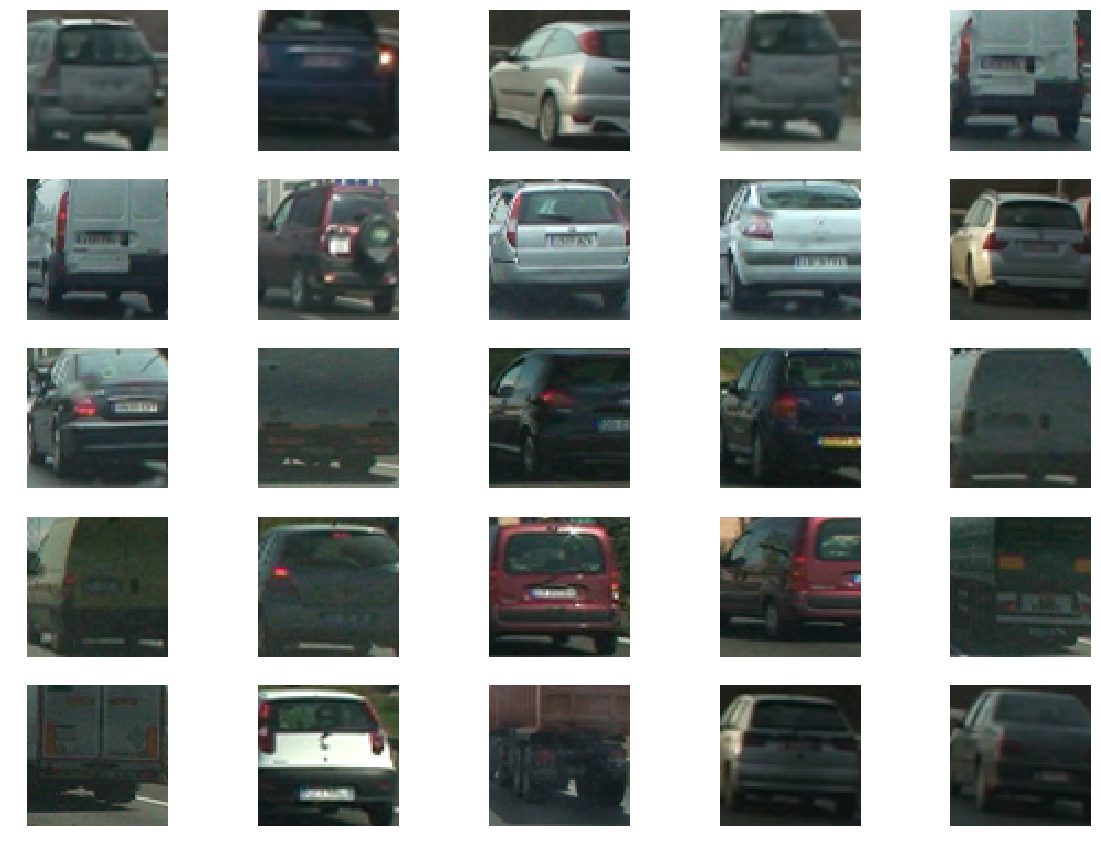

In [7]:
im = [plt.imread(image_df.iloc[i,0]) for i in range(len(image_df.iloc[:25,0]))]
create_subplots(im,5,5)

In [8]:
seed = np.random.RandomState(seed=52)

image_df = shuffle(image_df,random_state=seed)
test_image_df = image_df[0:round(len(image_df)*0.05)]
image_df = image_df[round(len(image_df)*0.05):]
print('Using {} images for training and testing \
the model and leaving {} for final testing'.format(len(image_df),len(test_image_df)))

Using 6959 images for training and testing the model and leaving 366 for final testing


## Histogram of Oriented Gradients <a name="hogs"></a>
***

In [9]:
def set_color_space(image,color_space='yuv'):
    if color_space == 'yuv':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'hls':
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    elif color_space == 'hsv':
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    elif color_space == 'rgb':
        image = image
    else:
        raise Exception('ERROR:', 'color_space not found.')
    
    return image

In [10]:
def preprocess_extract(frame,params):
    preprocessed_img = set_color_space(frame,color_space=params['color_space'])

    hogA, hogA_img = perform_hog(preprocessed_img[:, :, 0],params)
    hogB, hogB_img = perform_hog(preprocessed_img[:, :, 1],params)
    hogC, hogC_img = perform_hog(preprocessed_img[:, :, 2],params)
    
    return hogA, hogB, hogC, hogA_img, hogB_img, hogC_img

In [11]:
def perform_hog(frame, p):
    feat, hg_img = hog(frame, orientations=p['orientations'],
                       pixels_per_cell=p['pixels_per_cell'],
                       cells_per_block=p['cells_per_block'],
                       transform_sqrt=p['transform_sqrt'],
                       block_norm=p['block_norm'],
                       visualise=p['visualise'],
                       feature_vector=p['feature_vector'])

    return feat,hg_img 

In [12]:
def combine_channels(params, hogA, hogB, hogC, x_pix, 
                     y_pix, w_pix = None, h_pix = None):
        
        if h_pix is None and w_pix is None: 
            h_pix, w_pix = params['bounding_box'], params['bounding_box']
    
        height = h_pix // params['pixels_per_cell'][0]
        width = w_pix // params['pixels_per_cell'][0]
        y_start = y_pix // params['pixels_per_cell'][0]
        x_start = x_pix // params['pixels_per_cell'][0]
        y_end = y_start + height - 1
        x_end = x_start + width - 1

        hogA = hogA[y_start: y_end, x_start: x_end].ravel()
        hogB = hogB[y_start: y_end, x_start: x_end].ravel()
        hogC = hogC[y_start: y_end, x_start: x_end].ravel()
        hog = np.hstack((hogA, hogB, hogC))

        return hog

In [13]:
def get_features(frame, params):
    hogA, hogB, hogC, _, _, _, = preprocess_extract(frame,params)
    return combine_channels(params,hogA,hogB,hogC,0,0,frame.shape[1],frame.shape[0])

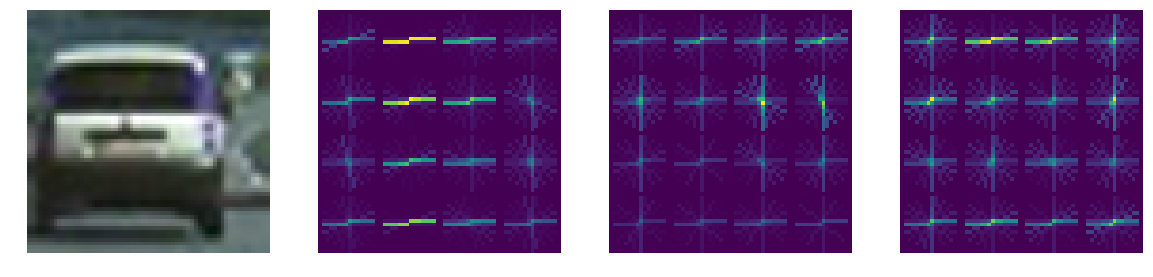

In [14]:
params = {
    'color_space': 'yuv',
    'orientations': 11, 
    'pixels_per_cell': (16,16),          
    'cells_per_block': (2,2),           
    'transform_sqrt': True,
    'block_norm': 'L2-Hys',
    'visualise': True,
    'feature_vector':False,
    'bounding_box': 64
}

im = cv2.imread(image_df.iloc[0,0])
_,_,_,img1,img2,img3 = preprocess_extract(im,params)
plot_images = [im,img1,img2,img3]

create_subplots(plot_images,1,4)

## Linear SVC <a name="svc"></a>
***

In [15]:
features = []

print('[Info] Extracting features...')
for i in range(len(image_df)):
    img = cv2.imread(image_df.iloc[i,0])
    features.append(get_features(img,params))

print('...Done')
features = np.asarray(features)
print('Features shape: ', features.shape,'\n')

unscaled_x = (features).astype(np.float64)
scaler = StandardScaler()
x = scaler.fit_transform(unscaled_x)
y = np.array(image_df[1])

print('[Info] Training classifier...')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = seed)
svc = LinearSVC()
svc.fit(x_train, y_train)
accuracy = svc.score(x_test, y_test)

print('...Done')
print('Accuracy: ', np.round(accuracy, 4))

[Info] Extracting features...
...Done
Features shape:  (6959, 1188) 

[Info] Training classifier...
...Done
Accuracy:  0.9461


## Testing <a name="testing"></a>
***
Testing on data that the classifier has not seen.

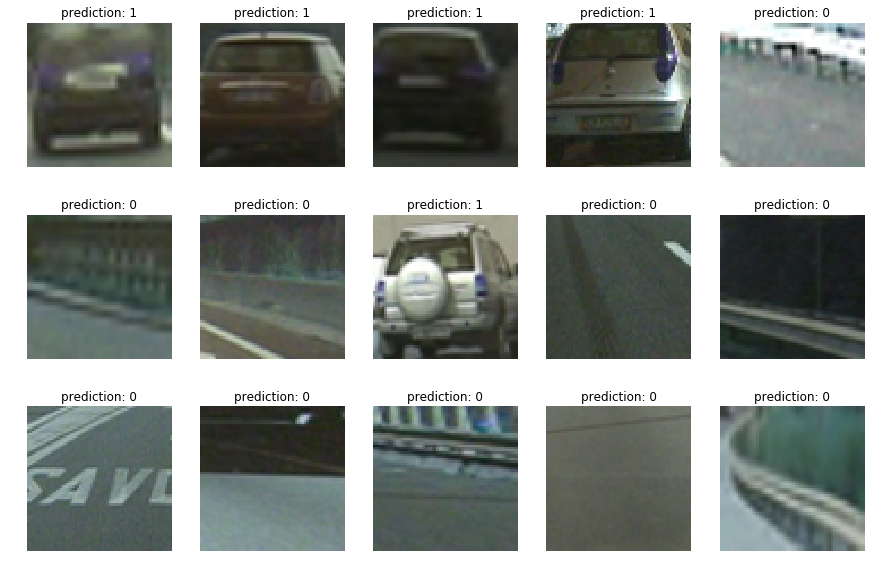

In [16]:
plt.figure(figsize=(15,10))
for i in range(len(test_image_df[:15])):
    img = cv2.imread(test_image_df.iloc[i,0])
    feat = get_features(img,params)
    feat = np.asarray([feat]).astype(np.float64)
    feat_scaled = scaler.transform(feat)
    pred = svc.predict(feat_scaled)
    plt.subplot(3,5,i+1)
    plt.imshow(img)
    plt.title('prediction: '+str(pred[0]))
    plt.axis('off')

## Detection <a name="detection"></a>
***
Let's retrieve the first frame of the test video.

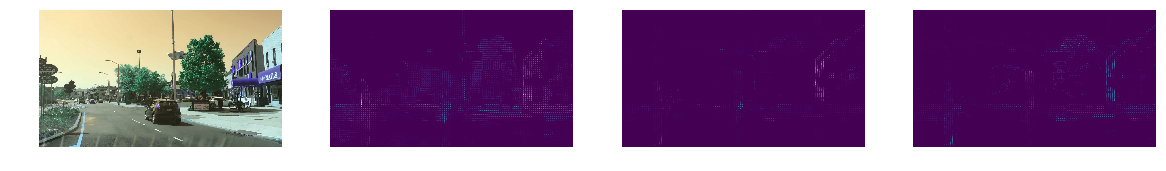

In [17]:
_,frame = cv2.VideoCapture('output.avi').read(1)
_,_,_,img1,img2,img3 = preprocess_extract(frame,params)
plot_images = [frame,img1,img2,img3]

create_subplots(plot_images,1,4)

In [18]:
def get_strip(frame,window_size,start_strip,height,increment):
    scale = window_size / height
    y_end = start_strip + window_size 
    w = np.int(frame.shape[1] / scale)

    strip = frame[start_strip:(start_strip+window_size),:,:]
    strip = cv2.resize(strip, (w, height))
    x_end = (strip.shape[1] // height - 1) * height
    
    return strip, x_end, scale

In [19]:
def get_bouding_boxes(strip,x_end,scale,hog_params,increment,scaler,svc,ss,ws):
    hogA, hogB, hogC, _, _, _, = preprocess_extract(strip,hog_params)
    boxes = []
    for resized_x in range(0, x_end, increment):
        features = combine_channels(hog_params,hogA,hogB,hogC,resized_x, 0)
        trans = scaler.transform([features])
        pred = svc.predict(trans)
        
        if pred[0]: 
            x = np.int(scale * resized_x)
            boxes.append((x, ss, ws))

    return boxes

In [20]:
def detect_object(frame,hog_params,ws,ss,height,increment,scaler,svc):
    strip, x_end, scale = get_strip(frame,ws,ss,height,increment)
    boxes = get_bouding_boxes(strip,x_end,scale,hog_params,increment,scaler,svc,ss,ws)
    frame_copy = frame.copy()
    for box in boxes:
        cv2.rectangle(frame_copy, (box[0], box[1]), (box[0] + box[2], box[1] + box[2]), (255,0,0), thickness=5)
        
    return frame_copy

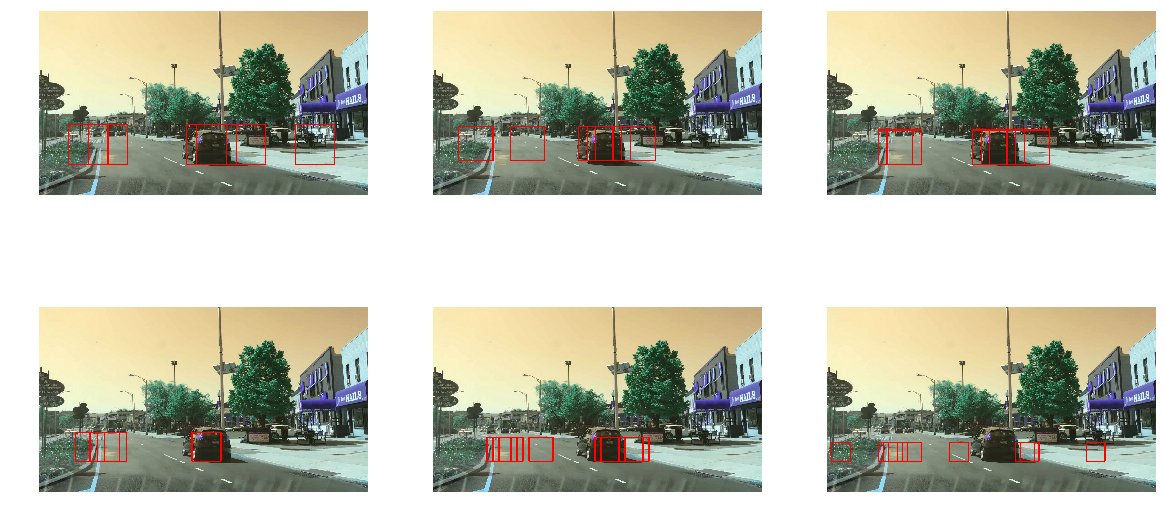

In [21]:
ss = [670, 680, 700, 730, 760, 790]
ws = [230, 200, 200, 170, 140, 110]
height = 64
increment = 16
img = []

for ss, ws in zip(ss, ws):
    frame_copy = detect_object(frame,params,ws,ss,height,increment,scaler,svc)
    img.append(frame_copy)

create_subplots(img,2,3,figsize=(20,10))

## Heatmap <a name="map"></a>
***

In [22]:
def draw(frame, memory, thresh,mapp,thresholded_map,samples_found):
    this_frame = frame.copy()
    thresholded_map = np.copy(mapp)
    thresholded_map[mapp < thresh] = 0
    
    labeled = label(thresholded_map)
    samples_found = labeled[1]
    labeled_map = labeled[0]
    this_map = labeled_map
    for n in range(1, samples_found + 1):
        coords =  (this_map == n).nonzero()
        xs, ys = np.array(coords[1]), np.array(coords[0])
        p1 = (np.min(xs), np.min(ys))
        p2 = (np.max(xs), np.max(ys))
        cv2.rectangle(this_frame, p1, p2, (0, 225, 0), thickness = 10)
    
    return this_frame

In [23]:
def remove_boxes(boxes,mapp):
    for box in boxes: 
        x1, y1, x2, y2 = box_boundaries(box)    
        mapp[y1: y2, x1: x2] -= 1

In [24]:
def add_boxes(boxes,mapp): 
    for box in boxes: 
        x1, y1, x2, y2 = box_boundaries(box)
        mapp[y1: y2, x1: x2] += 1

In [25]:
def box_boundaries(box):
    x1, y1 = box[0], box[1]
    x2, y2 = box[0] + box[2], box[1] + box[2]  
    return x1, y1, x2, y2

In [26]:
blank= None
thresholded_map= None
mapp = None
thresh = None
samples_found = 0
history = []
memory = None

def heatmap_test(this_frame, ws, ss,increment,thresh=8,memory=4):
    
    blank = np.zeros_like(this_frame[:, :, 0]).astype(np.float)
    mapp = np.copy(blank)
    thresh = thresh
    memory = memory    
    history = []

    for sz, pos in zip(ws, ss):
        
        strip, x_end, scale = get_strip(frame,sz,pos,height,increment)
        bounding_boxes = get_bouding_boxes(strip,x_end,scale,params,increment,scaler,svc,pos,sz)
        if len(history) == memory:
            remove_boxes(history[0])
            history = history[1:]
    
        add_boxes(bounding_boxes,mapp)
        history.append(bounding_boxes)

    new_frame = draw(this_frame,memory,thresh,mapp,thresholded_map,samples_found)
    return  new_frame

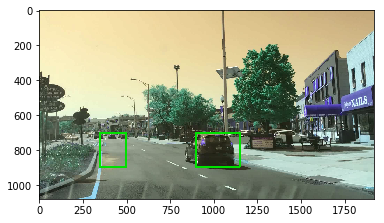

In [27]:
window_sizes = [200,200,200,200]
window_positions = [700,700,700,700]
_,frame = cv2.VideoCapture('output.avi').read(1)

a = heatmap_test(frame,window_sizes, window_positions,increment)
plt.imshow(a)

## Live Detection <a name="live"></a>
***

In [29]:
cap = cv2.VideoCapture('output.avi')
ws = 160
ss = 400
height = 64
increment = 16

window_sizes = 160,160,160,160
window_positions = 400,400,400,400

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize(frame, None,fx=0.6, fy=0.6, interpolation = cv2.INTER_LINEAR)
        frame_copy = heatmap_test(frame,window_sizes, window_positions,increment)
        cv2.imshow('Cars', frame_copy)

        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()